***Importamos las librerías necesarias :***

In [10]:
import os
import torch
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
from io import BytesIO
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torchvision.models import alexnet, AlexNet_Weights
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

***Guardamos las imágenes con sus respectivas clases en "complete_df" :***

In [2]:
zip_path = './Imagenes/Trayectorias_comprimidas/longitud_8/raw-img.zip'

complete_df = pd.DataFrame()

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    file_list = [f for f in zip_ref.namelist() if f.startswith('raw-img/') and f.lower().endswith(('.png'))]
    complete_df['file_name'] = pd.Series(file_list)
    complete_df['class_name'] = complete_df['file_name'].map(lambda x: x.split('/')[-2])

#### COMPROBACIÓN ####
print("Número total de imágenes:", len(complete_df))
class_counts = complete_df['class_name'].value_counts()
print(class_counts)

Número total de imágenes: 14486
class_name
Fishing      2927
Cargo        2919
Tanker       2892
Container    2886
Cruise       2862
Name: count, dtype: int64


***Dividimos "complete_df" en entrenamiento y test :***

In [3]:
complete_df = complete_df.sample(frac=1, random_state=42).reset_index(drop=True)

test_size = 0.2
train_df_list = []
test_df_list = []

classes = complete_df['class_name'].unique()

for class_name in classes:
    class_subset = complete_df[complete_df['class_name'] == class_name]
    
    test_count = int(len(class_subset) * test_size)
    
    test_df_list.append(class_subset.iloc[:test_count])
    train_df_list.append(class_subset.iloc[test_count:])

train_df = pd.concat(train_df_list).reset_index(drop=True)
test_df = pd.concat(test_df_list).reset_index(drop=True)

train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

#### COMPROBACIÓN ####
print(f"Nº de imágenes en train: {len(train_df)}")
print(train_df['class_name'].value_counts())
print()
print(f"Nº de imágenes en test: {len(test_df)}")
print(test_df['class_name'].value_counts())
print()
print("Ejm. conjunto train:")
print(train_df.head(10))
print()
print("Ejm. conjunto test:")
print(test_df.head(10))

Nº de imágenes en train: 11591
class_name
Fishing      2342
Cargo        2336
Tanker       2314
Container    2309
Cruise       2290
Name: count, dtype: int64

Nº de imágenes en test: 2895
class_name
Fishing      585
Cargo        583
Tanker       578
Container    577
Cruise       572
Name: count, dtype: int64

Ejm. conjunto train:
                                           file_name class_name
0      raw-img/Cargo/Trayectoria_comprimida_1392.png      Cargo
1  raw-img/Container/Trayectoria_comprimida_8636.png  Container
2    raw-img/Fishing/Trayectoria_comprimida_7630.png    Fishing
3     raw-img/Tanker/Trayectoria_comprimida_4458.png     Tanker
4      raw-img/Cargo/Trayectoria_comprimida_9364.png      Cargo
5    raw-img/Cruise/Trayectoria_comprimida_13954.png     Cruise
6     raw-img/Tanker/Trayectoria_comprimida_5989.png     Tanker
7     raw-img/Tanker/Trayectoria_comprimida_3979.png     Tanker
8     raw-img/Cruise/Trayectoria_comprimida_2111.png     Cruise
9    raw-img/Fishing/Trayect

***Imágenes de entrenamiento y test antes del pre-procesado :***

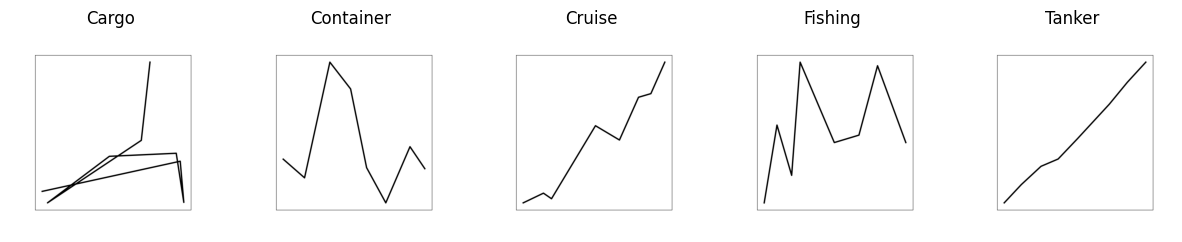

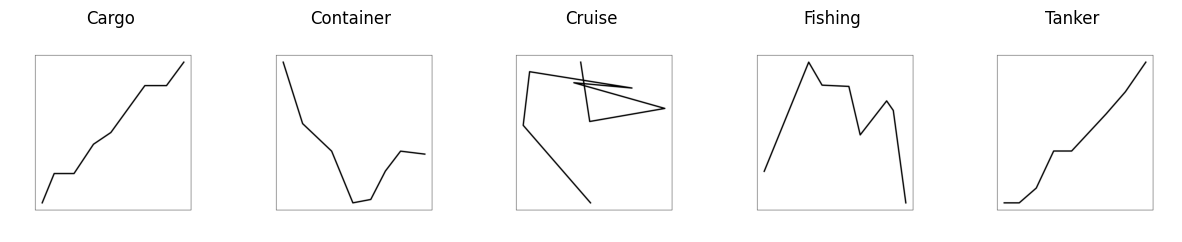

In [4]:
def mostrar_imagenes_antes_preprocesado(df):
    plt.figure(figsize=(15, 15))
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        grouped = df.groupby('class_name')
        for i, (class_name, group) in enumerate(grouped):
            image_path = group['file_name'].iloc[0]
            with zip_ref.open(image_path) as image_file:
                image = Image.open(image_file).convert("RGB")
            plt.subplot(1, len(grouped), i + 1)
            plt.imshow(image)
            plt.title(class_name)
            plt.axis('off')
    plt.show()

mostrar_imagenes_antes_preprocesado(train_df)
mostrar_imagenes_antes_preprocesado(test_df)


***Pre-procesado de las imágenes :***

In [5]:
IMG_SIZE = (227, 227)
X_train = []
y_train = []
X_test = []
y_test = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device} disponible")

transform = transforms.Compose([transforms.Resize(IMG_SIZE), transforms.ToTensor()])

def preprocesado_imagen(zip_ref, image_path):
    with zip_ref.open(image_path) as image_file:
        image = Image.open(image_file).convert("RGB")
        image = transform(image)
        return image

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for index, row in train_df.iterrows():
        image_tensor = preprocesado_imagen(zip_ref, row['file_name'])
        X_train.append(image_tensor)
        y_train.append(row['class_name'])

    for index, row in test_df.iterrows():
        image_tensor = preprocesado_imagen(zip_ref, row['file_name'])
        X_test.append(image_tensor)
        y_test.append(row['class_name'])

X_train = torch.stack(X_train)
X_test = torch.stack(X_test)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

encoder = OneHotEncoder(sparse_output=False, categories='auto')
#y_train = torch.tensor(encoder.fit_transform(y_train_encoded.reshape(-1, 1)), dtype=torch.float32)
#y_test = torch.tensor(encoder.transform(y_test_encoded.reshape(-1, 1)), dtype=torch.float32)
y_train = torch.tensor(y_train_encoded, dtype=torch.long)
y_test = torch.tensor(y_test_encoded, dtype=torch.long)

#### COMPROBACIÓN ####
print("X_train:", X_train.shape, X_train.device)
print("y_train:", y_train.shape, y_train.device)
print("X_test:", X_test.shape, X_test.device)
print("y_test:", y_test.shape, y_test.device)

cuda disponible
X_train: torch.Size([11591, 3, 227, 227]) cpu
y_train: torch.Size([11591]) cpu
X_test: torch.Size([2895, 3, 227, 227]) cpu
y_test: torch.Size([2895]) cpu


***Añadir conjunto de validación :***

In [6]:
batch_size = 32

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("X_train:", X_train.shape, X_train.device)
print("y_train:", y_train.shape, y_train.device)
print("X_val:", X_val.shape, X_val.device)
print("y_val:", y_val.shape, y_val.device)

X_train: torch.Size([9272, 3, 227, 227]) cpu
y_train: torch.Size([9272]) cpu
X_val: torch.Size([2319, 3, 227, 227]) cpu
y_val: torch.Size([2319]) cpu


***Datasets y DataLoaders :***

In [7]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)

***Modelo AlexNet :***

In [15]:
num_classes = 5

#Sin pesos preentrenados
#alexnet_scratch = alexnet(weights=None)
#alexnet_scratch.classifier[6] = nn.Linear(4096, num_classes)

#Con pesos preentrenados
alexnet_pretrained = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)
alexnet_pretrained.classifier[6] = nn.Linear(4096, num_classes)

***Inicialización del modelo :***

In [16]:
num_epochs = 25
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#modelo = alexnet_scratch.to(device)
modelo = alexnet_pretrained.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelo.parameters(), lr=0.001)

***Entrenamiento del modelo :***

In [17]:
train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []

for epoch in range(num_epochs):

    #Train
    modelo.train()
    total_loss = 0
    correct_train = 0
    total_train = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = modelo(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        _, predicted = torch.max(output, 1)
        actual = labels
        total_train += labels.size(0)
        correct_train += (predicted == actual).sum().item()

        progress_bar.set_postfix(loss=total_loss / (progress_bar.n + 1))

    avg_train_loss = total_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train

    #Val
    modelo.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = modelo(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            actual = labels
            total_val += labels.size(0)
            correct_val += (predicted == actual).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct_val / total_val

    train_accuracies.append(train_acc)
    train_losses.append(avg_train_loss)
    val_accuracies.append(val_acc)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} ✅ | Train Acc: {train_acc:.2f}% - Train Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.2f}% - Val Loss: {avg_val_loss:.4f}")

Epoch 1/25:   0%|          | 0/290 [00:00<?, ?it/s]

Epoch 1/25: 100%|██████████| 290/290 [00:17<00:00, 16.18it/s, loss=1.62]


Epoch 1/25 ✅ | Train Acc: 18.99% - Train Loss: 1.6175 | Val Acc: 20.40% - Val Loss: 1.6093


Epoch 2/25: 100%|██████████| 290/290 [00:18<00:00, 15.79it/s, loss=1.62]


Epoch 2/25 ✅ | Train Acc: 19.88% - Train Loss: 1.6109 | Val Acc: 18.93% - Val Loss: 1.6114


Epoch 3/25: 100%|██████████| 290/290 [00:18<00:00, 15.30it/s, loss=1.62]


Epoch 3/25 ✅ | Train Acc: 19.74% - Train Loss: 1.6105 | Val Acc: 19.49% - Val Loss: 1.6096


Epoch 4/25: 100%|██████████| 290/290 [00:18<00:00, 15.55it/s, loss=1.61]


Epoch 4/25 ✅ | Train Acc: 20.21% - Train Loss: 1.6110 | Val Acc: 20.40% - Val Loss: 1.6094


Epoch 5/25: 100%|██████████| 290/290 [00:18<00:00, 15.53it/s, loss=1.61]


Epoch 5/25 ✅ | Train Acc: 19.19% - Train Loss: 1.6097 | Val Acc: 18.93% - Val Loss: 1.6099


Epoch 6/25: 100%|██████████| 290/290 [00:18<00:00, 15.42it/s, loss=1.61]


Epoch 6/25 ✅ | Train Acc: 19.07% - Train Loss: 1.6098 | Val Acc: 20.70% - Val Loss: 1.6091


Epoch 7/25: 100%|██████████| 290/290 [00:18<00:00, 15.70it/s, loss=1.61]


Epoch 7/25 ✅ | Train Acc: 19.98% - Train Loss: 1.6099 | Val Acc: 20.40% - Val Loss: 1.6115


Epoch 8/25: 100%|██████████| 290/290 [00:18<00:00, 15.69it/s, loss=1.61]


Epoch 8/25 ✅ | Train Acc: 19.42% - Train Loss: 1.6105 | Val Acc: 19.49% - Val Loss: 1.6100


Epoch 9/25: 100%|██████████| 290/290 [00:18<00:00, 15.81it/s, loss=1.62]


Epoch 9/25 ✅ | Train Acc: 20.01% - Train Loss: 1.6102 | Val Acc: 20.40% - Val Loss: 1.6174


Epoch 10/25: 100%|██████████| 290/290 [00:18<00:00, 15.46it/s, loss=1.61]


Epoch 10/25 ✅ | Train Acc: 19.40% - Train Loss: 1.6107 | Val Acc: 20.40% - Val Loss: 1.6094


Epoch 11/25: 100%|██████████| 290/290 [00:18<00:00, 15.78it/s, loss=1.62]


Epoch 11/25 ✅ | Train Acc: 19.66% - Train Loss: 1.6099 | Val Acc: 18.93% - Val Loss: 1.6116


Epoch 12/25: 100%|██████████| 290/290 [00:18<00:00, 15.70it/s, loss=1.61]


Epoch 12/25 ✅ | Train Acc: 19.66% - Train Loss: 1.6104 | Val Acc: 18.93% - Val Loss: 1.6102


Epoch 13/25: 100%|██████████| 290/290 [00:18<00:00, 15.72it/s, loss=1.62]


Epoch 13/25 ✅ | Train Acc: 20.03% - Train Loss: 1.6098 | Val Acc: 19.49% - Val Loss: 1.6126


Epoch 14/25: 100%|██████████| 290/290 [00:18<00:00, 15.79it/s, loss=1.62]


Epoch 14/25 ✅ | Train Acc: 20.59% - Train Loss: 1.6103 | Val Acc: 19.49% - Val Loss: 1.6097


Epoch 15/25: 100%|██████████| 290/290 [00:18<00:00, 15.89it/s, loss=1.61]


Epoch 15/25 ✅ | Train Acc: 19.69% - Train Loss: 1.6103 | Val Acc: 19.49% - Val Loss: 1.6100


Epoch 16/25: 100%|██████████| 290/290 [00:18<00:00, 15.91it/s, loss=1.61]


Epoch 16/25 ✅ | Train Acc: 19.49% - Train Loss: 1.6099 | Val Acc: 19.49% - Val Loss: 1.6097


Epoch 17/25: 100%|██████████| 290/290 [00:18<00:00, 15.75it/s, loss=1.62]


Epoch 17/25 ✅ | Train Acc: 20.39% - Train Loss: 1.6099 | Val Acc: 18.93% - Val Loss: 1.6103


Epoch 18/25: 100%|██████████| 290/290 [00:18<00:00, 15.84it/s, loss=1.62]


Epoch 18/25 ✅ | Train Acc: 19.84% - Train Loss: 1.6101 | Val Acc: 19.49% - Val Loss: 1.6098


Epoch 19/25: 100%|██████████| 290/290 [00:18<00:00, 15.88it/s, loss=1.61]


Epoch 19/25 ✅ | Train Acc: 19.41% - Train Loss: 1.6100 | Val Acc: 18.93% - Val Loss: 1.6099


Epoch 20/25: 100%|██████████| 290/290 [00:18<00:00, 15.75it/s, loss=1.62]


Epoch 20/25 ✅ | Train Acc: 19.83% - Train Loss: 1.6100 | Val Acc: 20.70% - Val Loss: 1.6094


Epoch 21/25: 100%|██████████| 290/290 [00:18<00:00, 15.80it/s, loss=1.62]


Epoch 21/25 ✅ | Train Acc: 19.54% - Train Loss: 1.6099 | Val Acc: 19.49% - Val Loss: 1.6097


Epoch 22/25: 100%|██████████| 290/290 [00:18<00:00, 15.65it/s, loss=1.62]


Epoch 22/25 ✅ | Train Acc: 19.35% - Train Loss: 1.6100 | Val Acc: 19.49% - Val Loss: 1.6097


Epoch 23/25: 100%|██████████| 290/290 [00:18<00:00, 15.88it/s, loss=1.61]


Epoch 23/25 ✅ | Train Acc: 19.60% - Train Loss: 1.6102 | Val Acc: 19.49% - Val Loss: 1.6099


Epoch 24/25: 100%|██████████| 290/290 [00:18<00:00, 15.94it/s, loss=1.61]


Epoch 24/25 ✅ | Train Acc: 20.31% - Train Loss: 1.6097 | Val Acc: 19.49% - Val Loss: 1.6097


Epoch 25/25: 100%|██████████| 290/290 [00:18<00:00, 15.85it/s, loss=1.62]


Epoch 25/25 ✅ | Train Acc: 19.83% - Train Loss: 1.6100 | Val Acc: 19.49% - Val Loss: 1.6104


***AlexNet_8 :***

Epoch 25/25 ✅ | Train Acc: 19.88% - Train Loss: 1.6095 | Val Acc: 19.49% - Val Loss: 1.6097

***AlexNet_8 Transfer Learning :***

Epoch 25/25 ✅ | Train Acc: 19.83% - Train Loss: 1.6100 | Val Acc: 19.49% - Val Loss: 1.6104

***AlexNet_18 :***

Epoch 25/25 ✅ | Train Acc: 19.66% - Train Loss: 1.6097 | Val Acc: 20.09% - Val Loss: 1.6094

***AlexNet_28 :***

Epoch 25/25 ✅ | Train Acc: 20.15% - Train Loss: 1.6096 | Val Acc: 18.99% - Val Loss: 1.6106

***Graficar los resultados del entrenamiento :***

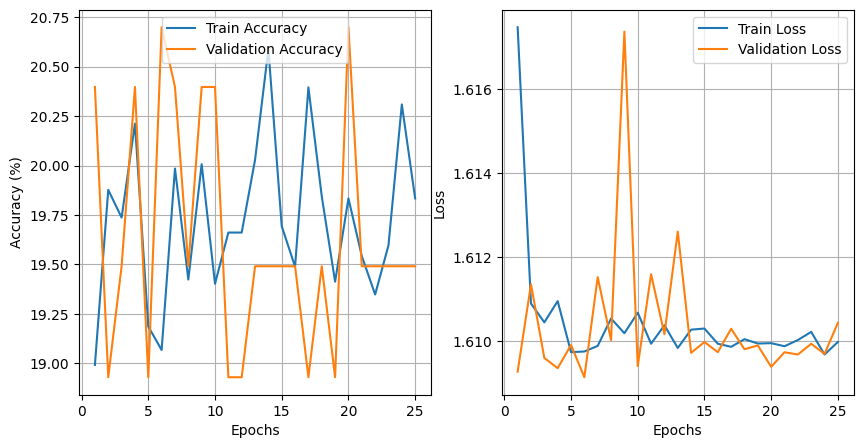

In [18]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

output_dir = './Resultados_entrenamiento/Representacion_2/'
os.makedirs(output_dir, exist_ok=True)
plt.savefig(f'{output_dir}AlexNet_8_con.png')
plt.show()